# Magnet Distance Notes

This notebooks contains my notes on determining magnet distance from the magnetic flux value, as the relationship between them isn't linear. The calculations here are based on the datasheets from the DRV5056.

![Magnet Dimensions](./magnet-distance/magnet-dimensions.png)

This formula can then be used to calculate the magnetic flux:

![Magnetic Flux Formula](./magnet-distance/magnetic-flux-formula.png)

The DRV5056 datasheet provided this magnetic profile for a 10mm x 6mm cylindrical ferrite magnet as reference:

![10mm x 6mm Cylindrical Magnet Profile](./magnet-distance/10x6-cylindrical-magnet.png)

In [949]:
# Imports
import numpy as np
from matplotlib import pyplot as plt

[71.93230414 69.89590061 67.91416263 65.9865631  64.11247356 62.2911756
 60.52187166 58.80369523 57.13572043 55.51697103 53.94642869 52.42304075
 50.94572726 49.51338751 48.12490593 46.77915744 45.47501234 44.2113406
 42.98701579 41.80091846 40.65193926 39.53898149 38.46096351 37.41682065
 36.40550696 35.42599657 34.47728495 33.55838979 32.66835181 31.80623534
 30.9711287  30.16214451 29.37841984 28.61911623 27.88341966 27.17054036
 26.4797126  25.81019445 25.16126737 24.53223585 23.922427   23.33119006
 22.75789592 22.20193663 21.66272483 21.13969328 20.63229423 20.13999895
 19.66229714 19.19869636 18.74872152 18.31191431 17.88783267 17.47605027
 17.07615597 16.68775329 16.31045999 15.94390747 15.58774039 15.24161613
 14.90520439 14.57818671 14.26025607 13.95111648 13.65048254 13.35807908
 13.07364078 12.7969118  12.52764544 12.2656038  12.01055741 11.76228497
 11.52057303 11.28521568 11.05601426 10.83277712 10.61531934 10.40346246
 10.19703426  9.99586853  9.79980482  9.60868823  9.4

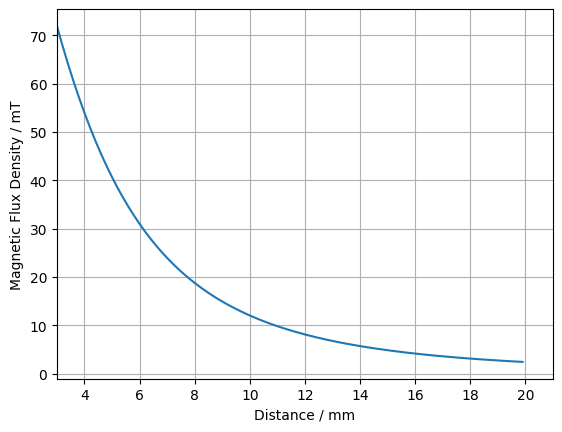

In [950]:
# Attempt to replicate the datasheet calculations
residual = 400 / 2.0    # In Millitesla
thickness = 6.0
diameter = 10.0
distances = np.arange(3, 20, 0.1)

radius_squared = (0.5 * diameter) ** 2

# Left fraction
lhs_numerator = distances + thickness
lhs_denominator = np.sqrt(radius_squared + (distances + thickness) ** 2)
lhs = lhs_numerator / lhs_denominator

# Right fraction
rhs_denominator = np.sqrt(radius_squared + (distances ** 2))
rhs = distances / rhs_denominator

# Calculate the final magnetic profile
magnetic_profile = residual * (lhs - rhs)

print(magnetic_profile)

plt.grid()
plt.xlim(3.0, 21.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, magnetic_profile)
plt.show()

[71.93230414 69.89590061 67.91416263 65.9865631  64.11247356 62.2911756
 60.52187166 58.80369523 57.13572043 55.51697103 53.94642869 52.42304075
 50.94572726 49.51338751 48.12490593 46.77915744 45.47501234 44.2113406
 42.98701579 41.80091846 40.65193926 39.53898149 38.46096351 37.41682065
 36.40550696 35.42599657 34.47728495 33.55838979 32.66835181 31.80623534
 30.9711287  30.16214451 29.37841984 28.61911623 27.88341966 27.17054036
 26.4797126  25.81019445 25.16126737 24.53223585 23.922427   23.33119006
 22.75789592 22.20193663 21.66272483 21.13969328 20.63229423 20.13999895
 19.66229714 19.19869636 18.74872152 18.31191431 17.88783267 17.47605027
 17.07615597 16.68775329 16.31045999 15.94390747 15.58774039 15.24161613
 14.90520439 14.57818671 14.26025607 13.95111648 13.65048254 13.35807908
 13.07364078 12.7969118  12.52764544 12.2656038  12.01055741 11.76228497
 11.52057303 11.28521568 11.05601426 10.83277712 10.61531934 10.40346246
 10.19703426  9.99586853  9.79980482  9.60868823  9.4

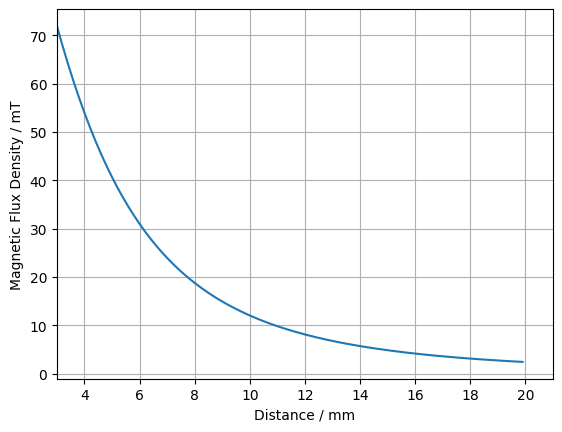

In [951]:
# Convert this into a re-usable function
def get_cylindrical_magnetic_profile(residual, thickness, diameter, distances):
    """ Function to calculate the magnetic profile for a cylindrical magnet. """
    residual = residual / 2.0
    radius_squared = (diameter / 2.0) ** 2
    
    # Left fraction
    lhs_numerator = distances + thickness
    lhs_denominator = np.sqrt(radius_squared + (distances + thickness) ** 2)
    lhs = lhs_numerator / lhs_denominator

    # Right fraction
    rhs_denominator = np.sqrt(radius_squared + (distances ** 2))
    rhs = distances / rhs_denominator

    return residual * (lhs - rhs)

distances = np.arange(3.0, 20.0, 0.1)
datasheet_profile = get_cylindrical_magnetic_profile(400, 6.0, 10.0, distances)

print(datasheet_profile)

plt.grid()
plt.xlim(3.0, 21.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, datasheet_profile)
plt.show()

## KS-20 Magnetic Profile

- Cylindrical Permanent Magnet
  - Thickness: 3.3mm
  - Diameter: 2.7mm
- PCB Thickness: 1.6mm
- Hall Element Centre: 0.65mm from bottom of chip
- Distance from Hall Element Centre: [2.55mm, 6.55mm]

[81.54295141 78.58001945 75.75641664 73.06430859 70.4963571  68.04568678
 65.70585385 63.47081702 61.33491037 59.29281801 57.3395506  55.47042335
 53.68103571 51.96725232 50.32518543 48.75117847 47.2417908  45.79378354
 44.40410639 43.06988535 41.78841133 40.55712956 39.3736297  38.23563664
 37.14100202 36.08769619 35.07380086 34.09750214 33.15708418 32.25092308
 31.37748136 30.53530272 29.72300715 28.93928642 28.18289978 27.45267003
 26.74747981 26.06626808 25.40802695 24.77179857 24.15667233 23.56178217
 22.9863041  22.42945385 21.89048468 21.36868531 20.863378   20.37391673
 19.89968549 19.44009668 18.99458961 18.56262907 18.14370402 17.73732629
 17.34302946 16.9603677  16.58891475 16.22826289 15.87802207 15.53781897
 15.20729622 14.88611155 14.57393714 14.27045884 13.97537555 13.68839859
 13.40925109 13.13766746 12.87339283 12.61618258 12.36580182 12.12202501
 11.88463544 11.65342492 11.42819333 11.20874828 10.99490478 10.78648488
 10.58331736 10.38523749 10.19208666]


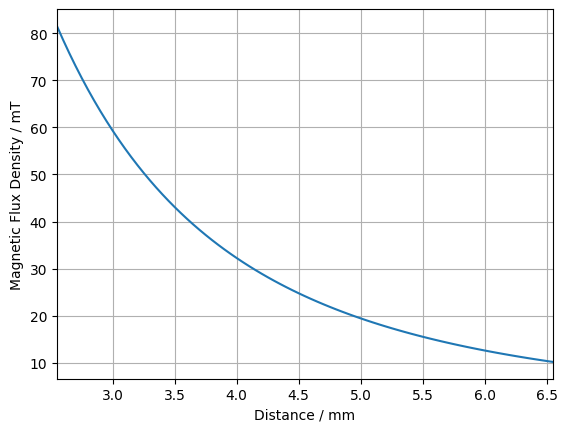

In [952]:
# At min distance (2.55mm), the magnetic flux is 905G, or 90.5mT
# At max distance (6.55mm), the magnetic flux is 102G, or 10.2mT
#
# After using TI's calculator, it looks like the residual induction is near 2000mT, but it's a bit off
# If only we had the actual magnet specs...
min_distance = 2.55
max_distance = 6.55
step = 0.05
distances = np.arange(min_distance, max_distance + step, step)
ks20_profile = get_cylindrical_magnetic_profile(1800, 3.3, 2.7, distances)

print(ks20_profile)

plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, ks20_profile)
plt.show()

[78.         78.         75.75641664 73.06430859 70.4963571  68.04568678
 65.70585385 63.47081702 61.33491037 59.29281801 57.3395506  55.47042335
 53.68103571 51.96725232 50.32518543 48.75117847 47.2417908  45.79378354
 44.40410639 43.06988535 41.78841133 40.55712956 39.3736297  38.23563664
 37.14100202 36.08769619 35.07380086 34.09750214 33.15708418 32.25092308
 31.37748136 30.53530272 29.72300715 28.93928642 28.18289978 27.45267003
 26.74747981 26.06626808 25.40802695 24.77179857 24.15667233 23.56178217
 22.9863041  22.42945385 21.89048468 21.36868531 20.863378   20.37391673
 19.89968549 19.44009668 18.99458961 18.56262907 18.14370402 17.73732629
 17.34302946 16.9603677  16.58891475 16.22826289 15.87802207 15.53781897
 15.20729622 14.88611155 14.57393714 14.27045884 13.97537555 13.68839859
 13.40925109 13.13766746 12.87339283 12.61618258 12.36580182 12.12202501
 11.88463544 11.65342492 11.42819333 11.20874828 10.99490478 10.78648488
 10.58331736 10.38523749 10.19208666]


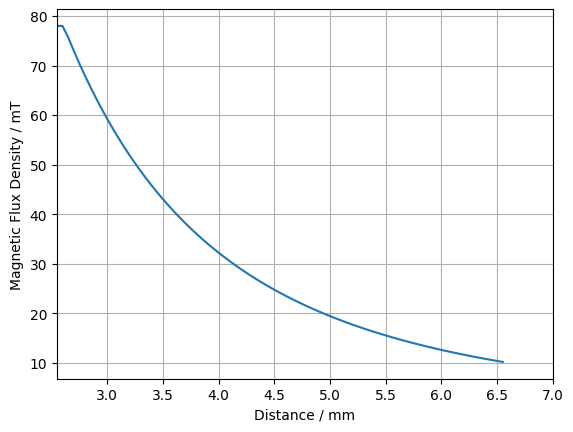

In [953]:
# If we clamp the maximum flux density to 78mT, we can find the minimum distance that can be detected
# In ideal conditions, we won't be able to detect the bottom 0.2mm of travel
ks20_profile_clamped = np.clip(ks20_profile, 0.0, 78.0)
print(ks20_profile_clamped)

plt.grid()
plt.xlim(2.55, 7.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, ks20_profile_clamped)
plt.show()

[3046.28854238 2957.40058362 2872.69249923 2791.92925764 2714.89071296
 2641.37060341 2571.17561552 2504.1245107  2440.04731102 2378.78454036
 2320.18651793 2264.11270064 2210.43107134 2159.01756968 2109.75556297
 2062.53535408 2017.25372394 1973.81350618 1932.1231916  1892.09656035
 1853.65233991 1816.71388686 1781.20889089 1747.06909932 1714.23006063
 1682.63088576 1652.2140257  1622.92506434 1594.7125254  1567.52769243
 1541.3244409  1516.05908165 1491.69021465 1468.17859259 1445.48699335
 1423.58010096 1402.42439418 1381.98804247 1362.24080851 1343.15395713
 1324.70016985 1306.85346504 1289.58912295 1272.88361548 1256.71454036
 1241.06055931 1225.9013401  1211.21750202 1196.99056482 1183.20290055
 1169.8376884  1156.87887221 1144.31112046 1132.11978864 1120.29088377
 1108.81103106 1097.66744241 1086.84788677 1076.34066215 1066.13456923
 1056.21888647 1046.58334655 1037.2181142  1028.11376521 1019.26126657
 1010.6519577  1002.27753276  994.13002382  986.20178498  978.48547734
  970.

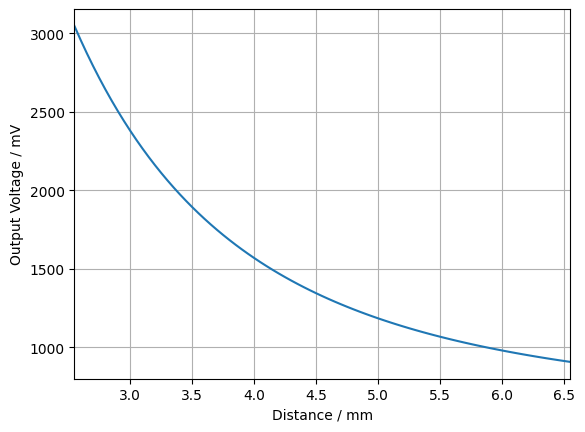

In [954]:
# Calculate the output voltage
quiescent_mv = 600
sensitivity_mv = 30
temperature = 25
ks20_mv = np.clip(quiescent_mv + ks20_profile * (sensitivity_mv * (1 + 0.0012 * (temperature - 25))), 0, 3300)

print(ks20_mv)
plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Output Voltage / mV')
plt.plot(distances, ks20_mv)
plt.show()

[3781.09026352 3670.76145166 3565.62075056 3465.37643615 3369.75526069
 3278.50120957 3191.37433974 3108.14969571 3028.61629877 2952.57620525
 2879.84362952 2810.24412783 2743.61383885 2679.7987774  2618.65417755
 2560.04388191 2503.83977371 2449.92124889 2398.17472509 2348.49318521
 2300.7757528  2254.92729714 2210.85806579 2168.48334267 2127.7231298
 2088.50185093 2050.74807553 2014.39426168 1979.37651638 1945.63437218
 1913.11057877 1881.75090861 1851.50397552 1822.32106522 1794.15597721
 1766.96487683 1740.70615714 1715.34030968 1690.82980354 1667.13897224
 1644.23390779 1622.08236146 1600.65365079 1579.91857243 1559.8493204
 1540.41940938 1521.60360274 1503.37784494 1485.71919803 1468.60578201
 1452.01671869 1435.93207896 1420.33283316 1405.20080432 1390.51862422
 1376.26969188 1362.43813458 1349.00877098 1335.96707642 1323.29915018
 1310.99168454 1299.03193559 1287.40769569 1276.10726737 1265.11943874
 1254.43346022 1244.03902248 1233.92623562 1224.08560948 1214.50803491
 1205.18

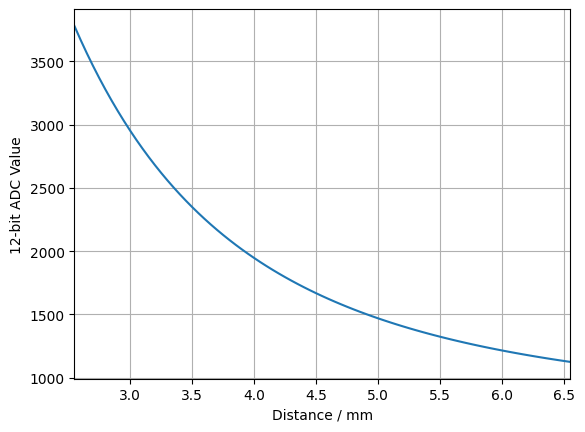

In [955]:
# Converting the voltages into 12-bit ADC values w/ 3.3V reference
ks20_adc = np.clip(4096 * (ks20_mv / 3300), 0, 4096)

print(ks20_adc)
plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('12-bit ADC Value')
plt.plot(distances, ks20_adc)
plt.show()

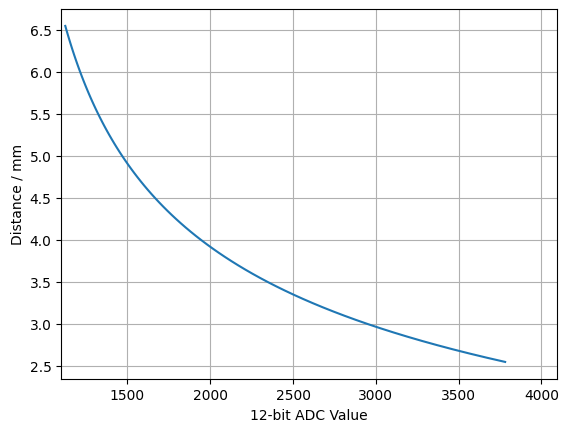

In [956]:
# If we plot in the other direction, we can come up with a lookup table for mapping ADC values -> distance
plt.grid()
plt.xlim(1100, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(ks20_adc, distances)
plt.show()

[1.54655642e+01 1.24458669e-03 2.58472268e+00]


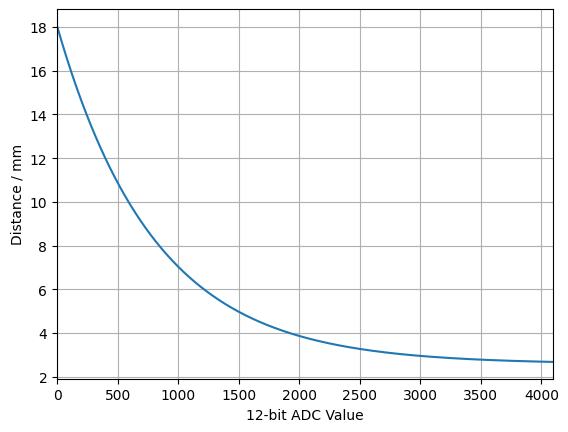

In [957]:
# An exponential function can be used for curve fitting
from scipy.optimize import curve_fit

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(exponential_func, ks20_adc, distances, p0=(1, 0.001, 6.5))
print(popt)

x = np.arange(0.0, 4096.0, 1.0)
y = exponential_func(x, *popt)

plt.grid()
plt.xlim(0.0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(x, y)

[   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.  272.  288.  304.  320.  336.  352.  368.
  384.  400.  416.  432.  448.  464.  480.  496.  512.  528.  544.  560.
  576.  592.  608.  624.  640.  656.  672.  688.  704.  720.  736.  752.
  768.  784.  800.  816.  832.  848.  864.  880.  896.  912.  928.  944.
  960.  976.  992. 1008. 1024. 1040. 1056. 1072. 1088. 1104. 1120. 1136.
 1152. 1168. 1184. 1200. 1216. 1232. 1248. 1264. 1280. 1296. 1312. 1328.
 1344. 1360. 1376. 1392. 1408. 1424. 1440. 1456. 1472. 1488. 1504. 1520.
 1536. 1552. 1568. 1584. 1600. 1616. 1632. 1648. 1664. 1680. 1696. 1712.
 1728. 1744. 1760. 1776. 1792. 1808. 1824. 1840. 1856. 1872. 1888. 1904.
 1920. 1936. 1952. 1968. 1984. 2000. 2016. 2032. 2048. 2064. 2080. 2096.
 2112. 2128. 2144. 2160. 2176. 2192. 2208. 2224. 2240. 2256. 2272. 2288.
 2304. 2320. 2336. 2352. 2368. 2384. 2400. 2416. 2432. 2448. 2464. 2480.
 2496. 2512. 2528. 2544. 2560. 2576. 2592. 2608. 26

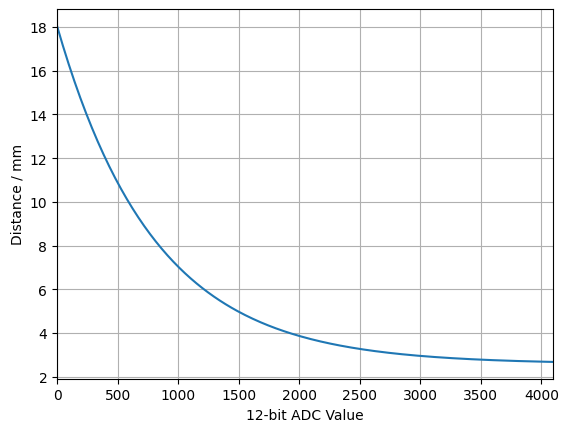

In [958]:
# A lookup table can then be generated from these values
# An extra value is needed for the maximum possible entry; this eliminates having to wrap around when performing lookups
lookup_bits = 4
lookup_step = 2 ** lookup_bits
lookup_x = np.arange(0, 4096.0 + lookup_step, lookup_step)
lookup_y = exponential_func(lookup_x, *popt)

print(lookup_x)
print(lookup_y)

plt.grid()
plt.xlim(0.0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(lookup_x, lookup_y)

In [959]:
# Using the lookup table and linear interpolation, we can find the distance for a particular ADC value
# Max allowed value is 4095
def distance_lerp(adc):
    lut_index = int(adc / lookup_step)

    adc0 = lut_index * lookup_step
    adc1 = adc0 + lookup_step

    dist0 = lookup_y[lut_index]
    dist1 = lookup_y[lut_index + 1]

    distance_lerp = dist0 + (dist1 - dist0) * (adc - adc0) / lookup_step

    print('ADC Value:', adc)
    print('LUT Index:', lut_index)
    print(f'Between ({adc0}, {dist0}) and {adc1, dist1}')
    print('Interpolated Distance:', distance_lerp)

# These values can be used as the reference for top/bottom
distance_lerp(1093)
print()
distance_lerp(4095)

ADC Value: 1093
LUT Index: 68
Between (1088, 6.577573917512411) and (1104, 6.4988491650710465)
Interpolated Distance: 6.552972432374484

ADC Value: 4095
LUT Index: 255
Between (4080, 2.681117978522772) and (4096, 2.6792174077499147)
Interpolated Distance: 2.679336193423218
